<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

To learn more about how object detection work, visit our [FAQ](../FAQ.md).

## Initialization

In [34]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [128]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
from torchvision import transforms

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bounding_boxes,
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_detection_vs_ground_truth,
)
from utils_cv.detection.model import DetectionLearner, get_bounding_boxes
from utils_cv.common.gpu import which_processor

which_processor()

Torch is using GPU: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if has any) and the computing device `torch/torchvision` is using.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [36]:
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS = 3
LEARNING_RATE = 0.005

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---

# Prepare Object Detection Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [37]:
path = Path(DATA_PATH)
os.listdir(path)

['.DS_Store', 'annotations', 'images']

You'll notice that we have two different folders inside:
- `/images`
- `/annotations`

This format for object detection is fairly common.

```
/data
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- annotations
|   +-- image1.xml
|   +-- image2.xml
|   +-- ...
+-- ...
```

Each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located. It also contains information about the bounding boxes and the object labels. In this example, our fridge object dataset is annotated in Pascal VOC format. This is one of the most common formats for labelling object detection datasets.

```xml
<!-- Example Pascal VOC annotation -->
<annotation>
    <folder>images</folder>
    <filename>1.jpg</filename>
    <path>../images/1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>499</width>
        <height>666</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>

    <object>
        <name>carton</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>173</ymin>
            <xmax>233</xmax>
            <ymax>521</ymax>
        </bndbox>
    </object>
</annotation>
```

You'll notice that inside the annotation xml file, we can see which image the file references `<path>`, the number of `<objects>` in the image, that the image is of (`<name>`) and the bounding box of that object (`<bndbox>`).

# Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use. In short, we'll need to create a class and implement the `__getitem__` method. More information here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset

To make it more convinient, we've created a `DetectionDataset` class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class. 

In [57]:
dataset = DetectionDataset(DATA_PATH, train_test_ratio=0.7)

Inspect our Datasets/DataLoaders to make sure the train/test split looks right.

In [58]:
print(
    f"Training dataset: {len(dataset.train_ds)} | Training DataLoader: {dataset.train_dl} \nTesting dataset: {len(dataset.test_ds)} | Testing DataLoader: {dataset.test_dl} \n"
)

Training dataset: 90 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f0bb8715780> 
Testing dataset: 38 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f0bb8715a90> 



Lets visualize some of the images to make sure the annotation looks correct.

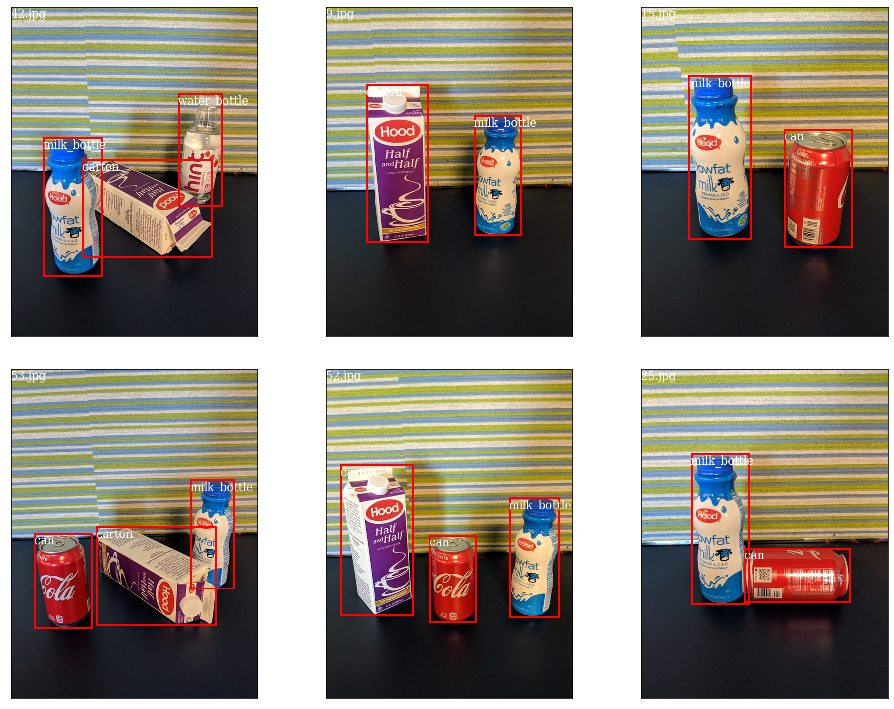

In [59]:
dataset.show_ims(rows=2, rand=True)

# Finetune a Pretrained Model

For the DetectionLearner, we use Faster R-CNN as the default model, and Stochastic Gradient Descent as our default optimizer. 

Our Faster R-CNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When we initialize the DetectionLearner, the object will perform the following steps:
1. set the model to the torchvision's Faster R-CNN
1. setup the optimizer, SGD in our case
1. set a learning rate scheduler to torch.optim.lr_scheduler.StepLR

In [60]:
detector = DetectionLearner(dataset, LEARNING_RATE)

Lets also check that our model, optimizer and learning rate scheduler are properly set.

In [61]:
print(
    f"Learning rate scheduler: {detector.lr_scheduler}\nOptimizer: {type(detector.optimizer)}\nModel: {type(detector.model)}"
)

Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f0bb85bd978>
Optimizer: <class 'torch.optim.sgd.SGD'>
Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


Fine-tune the model using our training data loader (`train_dl`) and evaluate our results using our testing data loader (`test_dl`).

In [66]:
detector.fit(EPOCHS, print_freq=30)

Epoch: [0]  [ 0/45]  eta: 0:00:20  lr: 0.000119  loss: 0.4188 (0.4188)  loss_classifier: 0.2184 (0.2184)  loss_box_reg: 0.1602 (0.1602)  loss_objectness: 0.0195 (0.0195)  loss_rpn_box_reg: 0.0206 (0.0206)  time: 0.4629  data: 0.2245  max mem: 4018
Epoch: [0]  [30/45]  eta: 0:00:03  lr: 0.003524  loss: 0.2111 (0.2578)  loss_classifier: 0.1355 (0.1459)  loss_box_reg: 0.0722 (0.0964)  loss_objectness: 0.0003 (0.0029)  loss_rpn_box_reg: 0.0113 (0.0125)  time: 0.1942  data: 0.0056  max mem: 4020
Epoch: [0]  [44/45]  eta: 0:00:00  lr: 0.005000  loss: 0.1394 (0.2163)  loss_classifier: 0.1023 (0.1277)  loss_box_reg: 0.0257 (0.0753)  loss_objectness: 0.0005 (0.0024)  loss_rpn_box_reg: 0.0073 (0.0109)  time: 0.1938  data: 0.0056  max mem: 4021
Epoch: [0] Total time: 0:00:09 (0.2008 s / it)
creating index...
index created!
Test:  [ 0/45]  eta: 0:00:15  model_time: 0.1156 (0.1156)  evaluator_time: 0.0063 (0.0063)  time: 0.3427  data: 0.2182  max mem: 4021
Test:  [44/45]  eta: 0:00:00  model_time: 

Visualize the loss over time.

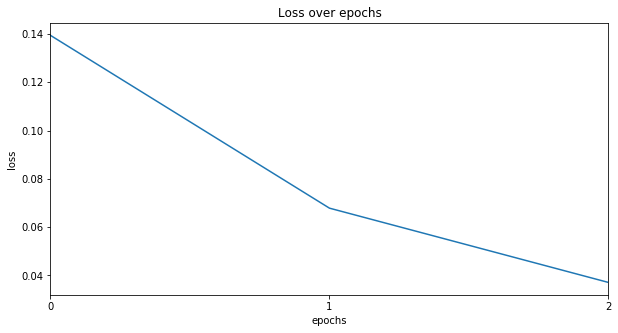

In [69]:
detector.plot_losses()

# Evaluate

We can simply run the `evaluate()` method on our detector to evaluate the results.

Below, you'll notice the notation IoU=0.5:0.95 in the results above. This means: the average mAP over different IoU thresholds, from 0.5 to 0.95, at step size of 0.05 (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95).

In [68]:
e = detector.evaluate()

creating index...
index created!
Test:  [ 0/19]  eta: 0:00:05  model_time: 0.1033 (0.1033)  evaluator_time: 0.0030 (0.0030)  time: 0.3130  data: 0.2043  max mem: 4025
Test:  [18/19]  eta: 0:00:00  model_time: 0.0730 (0.0752)  evaluator_time: 0.0029 (0.0028)  time: 0.0961  data: 0.0162  max mem: 4025
Test: Total time: 0:00:01 (0.0982 s / it)
Averaged stats: model_time: 0.0730 (0.0752)  evaluator_time: 0.0029 (0.0028)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ Io

Plot precision-recall curves. We'll use the `plot_pr_curves` function to plot the PR of each IoU threshold, and also the average over the IoU thresholds.

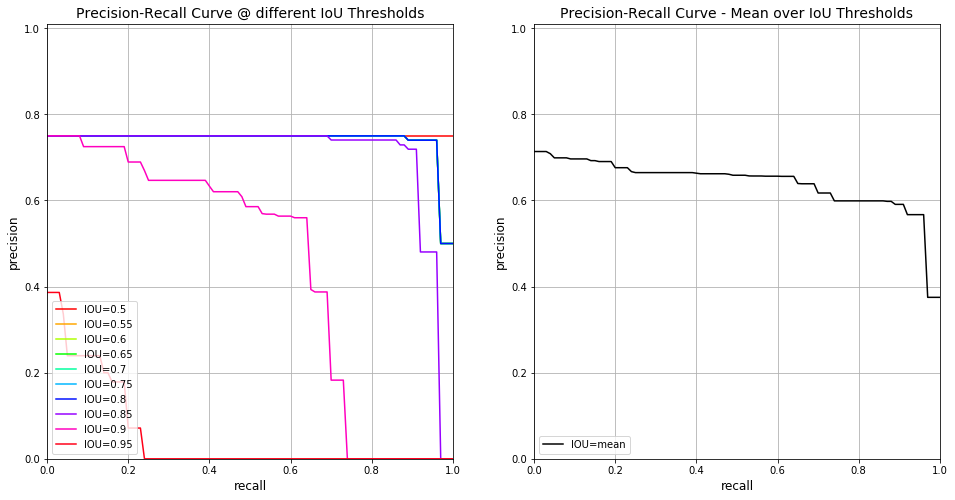

In [70]:
plot_pr_curves(e)

# Predict Batches

We can predict batches using the `pred_batch` function. We pass it a dataloader, and it will return a generator that does predictions on the by batch. In this case, we'll just use the test DataLoader (`test_dl`) that we created above. This uses the batch size set by the parameter `BATCH_SIZE`. 

In [122]:
batch_preds = detector.pred_batch(iter(dataset.test_dl), threshold=0.6)

The variable `batch_preds` is a generator. Use `next(batch_preds)` to get the predictions of each batch.

In [123]:
preds = next(batch_preds)
preds

[{'idx': 46,
  'anno_bboxes': [{Bbox object: [left=99, top=165, right=217, bottom=484] | <milk_bottle> | label:1},
   {Bbox object: [left=206, top=364, right=422, bottom=473] | <can> | label:2}]},
 {'idx': 14,
  'anno_bboxes': [{Bbox object: [left=99, top=170, right=217, bottom=486] | <water_bottle> | label:4}]}]

Lets say we have a batch size of 2, but we want to get 6 images, we can just run a for-loop over our `batch_preds` iterator and group the batches to get 6 image predictions.

In [124]:
detections = []
for preds in batch_preds:
    for pred in preds:
        if len(detections) < 6:
            detections.append(pred)
        else:
            break
detections

[{'idx': 23,
  'anno_bboxes': [{Bbox object: [left=98, top=409, right=458, bottom=524] | <water_bottle> | label:4}]},
 {'idx': 19,
  'anno_bboxes': [{Bbox object: [left=65, top=170, right=182, bottom=460] | <water_bottle> | label:4}]},
 {'idx': 64,
  'anno_bboxes': [{Bbox object: [left=134, top=176, right=225, bottom=411] | <milk_bottle> | label:1},
   {Bbox object: [left=251, top=125, right=337, bottom=350] | <water_bottle> | label:4}]},
 {'idx': 115,
  'anno_bboxes': [{Bbox object: [left=29, top=263, right=139, bottom=512] | <milk_bottle> | label:1},
   {Bbox object: [left=357, top=213, right=461, bottom=442] | <water_bottle> | label:4},
   {Bbox object: [left=286, top=308, right=382, bottom=466] | <can> | label:2}]},
 {'idx': 98,
  'anno_bboxes': [{Bbox object: [left=0, top=318, right=104, bottom=497] | <can> | label:2},
   {Bbox object: [left=373, top=242, right=480, bottom=487] | <milk_bottle> | label:1},
   {Bbox object: [left=233, top=208, right=327, bottom=450] | <water_bottle>

We now have 6 predictions on 6 different images from out test set. Since the data is from the test set, we also know what the ground truth bounding boxes for those images are too. Lets plot the ground truth vs predictions for the six images. 

To plot the predictions, we'll create a simple function (`get_im_and_bboxes()`) to create a generator that returns the data needed to plot the ground truths vs the detections. This generator returns a new `im_path`, `detection_anno_bboxes`, and `ground_truth_anno_bboxes` each time it is iterated on.

Since these are the parameters that the `plot_detection_vs_ground_truth()` function takes, we can pass the entire iterator object to the `plot_grid()` function. For each plot it produces, it will use a new iteration from the generator.

The red boxes represents the ground truth while the green represents the predected bounding box.

In [129]:
def get_im_and_bboxes() -> Iterator:
    for detection in detections:
        idx = detection['idx']
        detection_anno_bboxes = detection['anno_bboxes']
        ground_truth_anno_bboxes, im_path = dataset._read_anno_idx(idx)
        yield im_path, detection_anno_bboxes, ground_truth_anno_bboxes

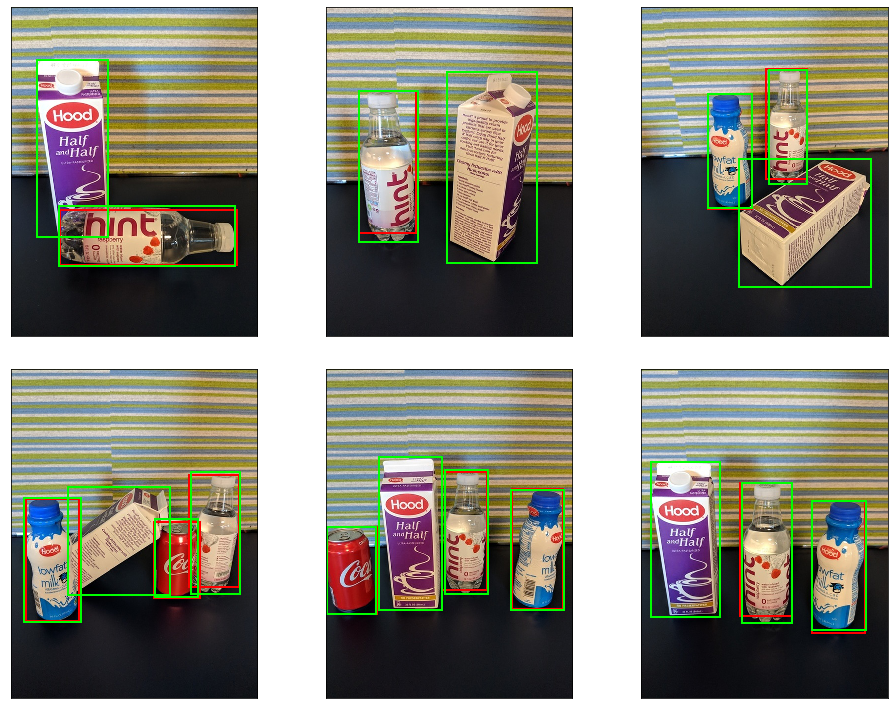

In [130]:
plot_grid(plot_detection_vs_ground_truth, get_im_and_bboxes(), rows=2)

# Predict Single Image

We can use the detector to predict new images. Start by getting a new image. In this case, we'll reuse a random image in our dataset and pretend it is a new image.

In [132]:
new_im_path = dataset.root / dataset.im_dir / dataset.im_paths[randrange(len(dataset))]
new_im_path

PosixPath('/home/jiata/code/cvbp/data/odFridgeObjects/images/19.jpg')

We can use the inference function:

In [133]:
new_im = Image.open(new_im_path)
preds = detector.predict(new_im, threshold=0.6)

Now that we have our predictions, lets plot the predictions on our image.

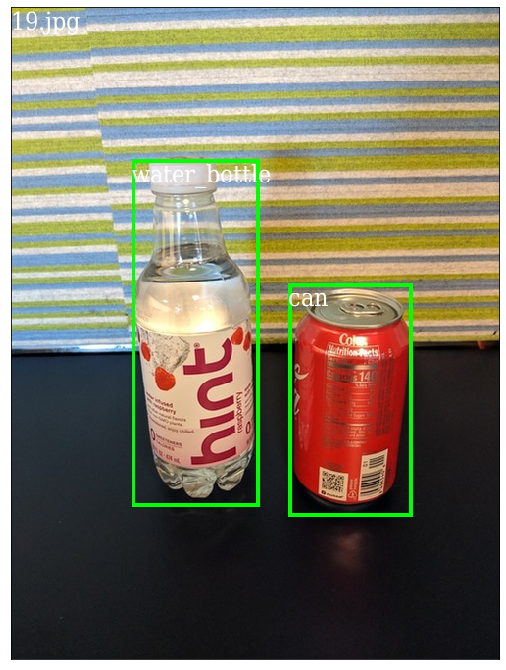

In [134]:
plot_settings = PlotSettings(rect_color=(0, 255, 0))

display_bounding_boxes(
    preds,
    new_im_path,
    plot_settings=plot_settings,
)